In [1]:

import numpy as np
from numba import jit

def randint_numpy(n):
    return np.random.randint(0, 10000, n)

@jit
def randint_numpy_jit(n):
    return np.random.randint(0, 10000, n)

%timeit randint_numpy(5)
%timeit randint_numpy_jit(5)


3.7 µs ± 293 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
The slowest run took 9.33 times longer than the fastest. This could mean that an intermediate result is being cached.
5.34 µs ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
from pyparsing import Word, delimitedList, Optional, \
    Group, alphas, alphanums, Forward, oneOf, quotedString, \
    infixNotation, opAssoc, ParseResults, \
    ZeroOrMore, restOfLine, CaselessKeyword, pyparsing_common as ppc
import matplotlib.pyplot as plt
import copy
%matplotlib inline
# define SQL tokens
selectStmt = Forward()
SELECT, FROM, WHERE, AND, OR, IN, IS, NOT, NULL, COUNT, AVG, MIN, MAX, SUM, AS = map(CaselessKeyword, 
    "select from where and or in is not null count avg min max sum as".split())
NOT_NULL = NOT + NULL

ident          = Word( alphas, alphanums + "_$" ).setName("identifier")
alias          = delimitedList(ident, ".", combine=True).setName("alias")
alias.addParseAction(ppc.upcaseTokens)
columnName     = delimitedList(ident, ".", combine=True).setName("column name")
columnName.addParseAction(ppc.upcaseTokens)
columnNameList = Group( delimitedList(columnName))
tableName      = delimitedList(ident, ".", combine=True).setName("table name")
tableName.addParseAction(ppc.upcaseTokens)
tableNameRalias= Group(
    (tableName("table") + AS + alias("alias")) |
    (tableName("table"))
    )

tableNameList  = Group(delimitedList(tableNameRalias))

binop = oneOf("= != < > >= <= eq ne lt le gt ge", caseless=True)
realNum = ppc.real()
intNum = ppc.signed_integer()

columnRval = realNum | intNum | quotedString | columnName # need to add support for alg expressions
val = realNum | intNum | quotedString
columnRstar = '*' | columnName # need to add support for alg expressions
EquiJoin =     (columnName('col1') + '=' + columnName ('col2'))
equalityPredicate = columnName('col1') + '=' + columnRval ('val')
Predicates =     Group(( columnName('col1') + binop + columnRval ) |
    ( columnName('col1') + IN + Group("(" + delimitedList( columnRval ) + ")" )) |
    ( columnName('col1') + IN + Group("(" + selectStmt + ")" )) |
    ( columnName + IS + (NULL | NOT_NULL)))

whereCondition = Group(
    EquiJoin ('equijoin') |
    equalityPredicate ('equalitypredicate') |
    Predicates ('otherPredicates')
    )

whereCondition_sketch = Group(
    EquiJoin ('equijoin') |
    equalityPredicate ('equalitypredicate') 
    )

Aggregates = Group(
     ((COUNT|AVG|MIN|MAX|SUM)("operator") + (Group ("("+columnName+")"))("operand") ) |
     (COUNT("operator") + Group("("+"*"+")")("operand"))
    )

AggregateExpression = delimitedList(Aggregates)

whereExpression_predicates = infixNotation(whereCondition_sketch,
    [
        (AND, 2, opAssoc.LEFT),
    ])

whereExpression = infixNotation(whereCondition,
    [
        (NOT, 1, opAssoc.RIGHT),
        (AND, 2, opAssoc.LEFT),
        (OR, 2, opAssoc.LEFT),
    ])

# define the grammar
selectStmt <<= (SELECT + ((AggregateExpression)("aggregates") | ('*' | columnNameList)("columns")) +
                FROM + tableNameList( "tables" ) +
                WHERE +(whereExpression_predicates)("sketch_predicates")+ Optional((whereExpression)("predicates")))

simpleSQL = selectStmt

# define Oracle comment format, and ignore them
oracleSqlComment = "--" + restOfLine
simpleSQL.ignore( oracleSqlComment )

if __name__ == "__main__":
    simpleSQL.runTests("""\
        # multiple tables
        SELECT * from XYZZY, ABC WHERE 
        # dotted table name
        select * from SYS.XYZZY
        Select A from Sys.dual
        Select A,B,C from Sys.dual
        Select A, B, C from Sys.dual, Table2
        # FAIL - invalid SELECT keyword
        Xelect A, B, C from Sys.dual
        # FAIL - invalid FROM keyword
        Select A, B, C frox Sys.dual
        # FAIL - incomplete statement
        SelectR
        # FAIL - incomplete statement
        Select * from
        # FAIL - invalid column
        Select &&& frox Sys.dual
        # where clause
        Select A from Sys.dual where a in ('RED','GREEN','BLUE')
        # compound where clause
        Select A from Sys.dual where a in ('RED','GREEN','BLUE') and b in (10,20,30)
        # where clause with comparison operator
        Select A,b from table1,table2 where table1.id eq table2.id
        """)


# multiple tables
SELECT * from XYZZY, ABC WHERE
                              ^
FAIL: Expected {"and" term | Group:({{column name "=" column name} | {column name "=" {real number | signed integer | quotedString using single or double quotes | column name}}}) | {Suppress:("(") Forward: ... Suppress:(")")}} (at char 30), (line:1, col:31)

# dotted table name
select * from SYS.XYZZY
                       ^
FAIL: Expected "where" (at char 23), (line:1, col:24)


Select A from Sys.dual
                      ^
FAIL: Expected "where" (at char 22), (line:1, col:23)


Select A,B,C from Sys.dual
                          ^
FAIL: Expected "where" (at char 26), (line:1, col:27)


Select A, B, C from Sys.dual, Table2
                                    ^
FAIL: Expected "where" (at char 36), (line:1, col:37)

# FAIL - invalid SELECT keyword
Xelect A, B, C from Sys.dual
^
FAIL: Expected "select" (at char 0), (line:1, col:1)

# FAIL - invalid FROM keyword
Select A, B, C frox Sys.dual
               

In [49]:
for x in simpleSQL.runTests("select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 AS T2 where table1.id = table2.id AND table1.wage = 4000"):
    print(x)
    print('\n')


select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 AS T2 where table1.id = table2.id AND table1.wage = 4000
['select', ['count', ['(*)']], ['avg', ['(', 'T2.MM', ')']], ['max', ['(', 'T1.SS', ')']], 'from', [['TABLE1', 'as', 'T12'], ['TABLE2', 'as', 'T2']], 'where', [['TABLE1.ID', '=', 'TABLE2.ID'], 'and', ['TABLE1.WAGE', '=', 4000]]]
- aggregates: [['count', ['(*)']], ['avg', ['(', 'T2.MM', ')']], ['max', ['(', 'T1.SS', ')']]]
  [0]:
    ['count', ['(*)']]
    - operand: ['(*)']
    - operator: 'count'
  [1]:
    ['avg', ['(', 'T2.MM', ')']]
    - operand: ['(', 'T2.MM', ')']
    - operator: 'avg'
  [2]:
    ['max', ['(', 'T1.SS', ')']]
    - operand: ['(', 'T1.SS', ')']
    - operator: 'max'
- sketch_predicates: [['TABLE1.ID', '=', 'TABLE2.ID'], 'and', ['TABLE1.WAGE', '=', 4000]]
  [0]:
    ['TABLE1.ID', '=', 'TABLE2.ID']
    - col1: 'TABLE1.ID'
    - col2: 'TABLE2.ID'
    - equijoin: ['TABLE1.ID', '=', 'TABLE2.ID']
  [1]:
    and
  [2]:
    ['TABLE1.WAGE', '=', 4000

In [50]:
simpleSQL.parseString("select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 where table1.id = table2.id AND table1.wage = 4000")

(['select', (['count', (['(*)'], {})], {'operator': ['count'], 'operand': [(['(*)'], {})]}), (['avg', (['(', 'T2.MM', ')'], {})], {'operator': ['avg'], 'operand': [(['(', 'T2.MM', ')'], {})]}), (['max', (['(', 'T1.SS', ')'], {})], {'operator': ['max'], 'operand': [(['(', 'T1.SS', ')'], {})]}), 'from', ([(['TABLE1', 'as', 'T12'], {'table': ['TABLE1'], 'alias': ['T12']}), (['TABLE2'], {'table': ['TABLE2']})], {}), 'where', ([(['TABLE1.ID', '=', 'TABLE2.ID'], {'col1': ['TABLE1.ID'], 'col2': ['TABLE2.ID'], 'equijoin': [(['TABLE1.ID', '=', 'TABLE2.ID'], {})]}), 'and', (['TABLE1.WAGE', '=', 4000], {'col1': ['TABLE1.WAGE'], 'val': [4000], 'equalitypredicate': [(['TABLE1.WAGE', '=', 4000], {})]})], {})], {'aggregates': [([(['count', (['(*)'], {})], {'operator': ['count'], 'operand': [(['(*)'], {})]}), (['avg', (['(', 'T2.MM', ')'], {})], {'operator': ['avg'], 'operand': [(['(', 'T2.MM', ')'], {})]}), (['max', (['(', 'T1.SS', ')'], {})], {'operator': ['max'], 'operand': [(['(', 'T1.SS', ')'], {

In [51]:
ParseResults = simpleSQL.parseString("select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 where table1.id = table2.id AND table1.wage = 4000",parseAll=True)
for x in ParseResults.items():
    print(x)
    print('\n')
for agg in ParseResults['aggregates']:
    print(dict(agg))
for table in ParseResults['tables']:
    print(dict(table))
for predicate in ParseResults['sketch_predicates']:
    if type(predicate) == str:
        pass
    else:
        print(dict(predicate))


('aggregates', ([(['count', (['(*)'], {})], {'operator': ['count'], 'operand': [(['(*)'], {})]}), (['avg', (['(', 'T2.MM', ')'], {})], {'operator': ['avg'], 'operand': [(['(', 'T2.MM', ')'], {})]}), (['max', (['(', 'T1.SS', ')'], {})], {'operator': ['max'], 'operand': [(['(', 'T1.SS', ')'], {})]})], {}))


('tables', ([(['TABLE1', 'as', 'T12'], {'table': ['TABLE1'], 'alias': ['T12']}), (['TABLE2'], {'table': ['TABLE2']})], {}))


('sketch_predicates', ([(['TABLE1.ID', '=', 'TABLE2.ID'], {'col1': ['TABLE1.ID'], 'col2': ['TABLE2.ID'], 'equijoin': [(['TABLE1.ID', '=', 'TABLE2.ID'], {})]}), 'and', (['TABLE1.WAGE', '=', 4000], {'col1': ['TABLE1.WAGE'], 'val': [4000], 'equalitypredicate': [(['TABLE1.WAGE', '=', 4000], {})]})], {}))


{'operator': 'count', 'operand': (['(*)'], {})}
{'operator': 'avg', 'operand': (['(', 'T2.MM', ')'], {})}
{'operator': 'max', 'operand': (['(', 'T1.SS', ')'], {})}
{'table': 'TABLE1', 'alias': 'T12'}
{'table': 'TABLE2'}
{'col1': 'TABLE1.ID', 'col2': 'TABLE2.ID',

In [52]:
import networkx as nx

def CreateJoinGraph(queryString):
    ParseResults = simpleSQL.parseString(queryString,parseAll=True)
    print('\n')
    
    if "columns" in ParseResults:
        assert(0) # cannot return result using AQP
        
    aggregate_list = []
    table_dict = {}
    equi_joins_set = set([])
    predicates_set = set([])
    
    for aggregate in ParseResults['aggregates']:
        aggregate_list.append(aggregate)
        
    for table in ParseResults['tables']:
        if 'alias' in table:
            name = table['alias']
        else:
            name = table['table']
        if name in table_dict:
            assert(0) # cannot have duplicate names for tables
        else:
            table_dict[name] = table['table']
            
    for predicate in ParseResults['sketch_predicates']:
        if predicate == 'and':
            pass
        elif type(predicate) == type(ParseResults):
            if 'equijoin' in predicate:
                alias,column = predicate['col1'].split('.') # throws error if malformed column
                alias2,column2 = predicate['col2'].split('.')
                assert(alias in table_dict and alias2 in table_dict)
                equi_joins_set.add( (alias,column, alias2,column2) )
            elif 'equalitypredicate' in predicate:
                alias,column = predicate['col1'].split('.')
                assert(alias in table_dict)                
                value = predicate['val']
                predicates_set.add( (alias,column,value) )
            else:
                assert(0) # unexpected value in sketch_predicates
        else:
            assert(0) # unexpected value in sketch_predicates
    
    G = nx.Graph()
    for ident, table_name in table_dict.items():
        G.add_node(ident, table_name = table_name)
    for equi_join in equi_joins_set:
        alias, _, alias2, _ = equi_join
        G.add_edge(alias,alias2)
        G[alias][alias2]['equijoin'] = equi_join
    if predicates_set:
        G.add_node('__imaginary_table__')
        for predicate in predicates_set:
            alias, _, _ = predicate
            G.add_edge('__imaginary_table__',alias)
            G['__imaginary_table__'][alias]['predicate'] = predicate
    return G

G = CreateJoinGraph("select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 where T12.id = table2.id AND T12.wage = 4000")


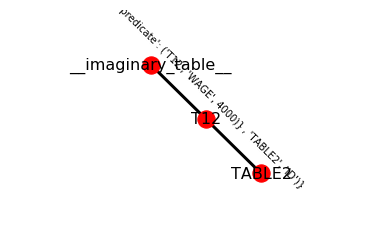

In [55]:
fig, ax = plt.subplots()
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

pos = nx.spring_layout(G)
pos2 = copy.deepcopy(pos) 
for p in pos2:  # raise text positions
    pos2[p][1] += 0.5


nx.draw_networkx_edge_labels(G,pos = pos2,ax = ax)
nx.draw(G,pos = pos,ax = ax,width = 3, font_size=16, with_labels=True)
